<p align="left">
  <img src="https://img.shields.io/badge/Research%20Mode-ON-4cbb17?style=for-the-badge" alt="Research Mode">
</p>

# 03 · Downstream Analysis — ASAP CRN Learning Lab  
*A guided launchpad for your second ASAP-CRN workspace adventure.*

Welcome to the **ASAP-CRN Learning Lab Pilot Workshop Series!**  

This notebook walks you through the basics of downstream analyses in **Verily Workbench**.

> **Prerequisite:** Run  **[02_data_exploration.ipynb](./02_data_exploration.ipynb)** and load the saved subset H5AD object before continuing.

> **Tip:** Run each cell in order for the smoothest setup experience.  
> You can always come back later to experiment and make it your own.

In [1]:
import sys, subprocess, importlib, warnings, os, logging, math, pandas as pd
from pathlib import Path

def setup_environment():
    """Configure logging, warnings, pandas options, and auto-install core packages."""

    def import_or_install(pkg, name=None):
        try:
            return importlib.import_module(name or pkg)
        except ImportError:
            print(f"{pkg} not found. Installing...")
            subprocess.run([sys.executable, "-m", "pip", "install", pkg], check=True)
            return importlib.import_module(name or pkg)

    env = {
        "pd": pd,
        "np": import_or_install("numpy"),
        "plt": import_or_install("matplotlib.pyplot", "matplotlib.pyplot"),
        "sns": import_or_install("seaborn"),
        "Image": import_or_install("PIL.Image", "PIL.Image"),
        "sc": import_or_install("scanpy"),
        "smf": import_or_install("statsmodels.formula.api", "statsmodels.formula.api")
    }
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 1200)
    
    print("Environment ready.")
    return env


In [2]:
env = setup_environment()
pd, np, plt, sns, Image, sc, smf = (
    env["pd"], env["np"], env["plt"], env["sns"],
    env["Image"], env["sc"], env["smf"]
)

Environment ready.


1. [Workspace Setup](#workspace-setup) 
    - [1.1 Define Dataset Paths](#set-dataset-paths)
    - [1.2 Load Required Data](#load-required-data)
2. [Pseudobulk Construction](#pseudobulk-construction)
3. [Differential Expression (DE) Analysis](#differential-expression-(de)-analysis)
    - [3.1 Cumputer Differential Expression](#calculate-differential-expression)
    - [3.2 Visualize with Volcano Plot](#visualize-with-volcano-plot)
4. [Compositional Analysis of Prefrontal Cortex Cells](compositional-analysis-of-prefrontal-cortex-cells)
    - [4.1 Global Cell-Type Abundance by Primary Diagnosis](#global-cell-type-abundance-by-primary-diagnosis)
    - [4.2 Proportional Cell-Type Abundance by Primary Diagnosis](#proportional-cell-type-abundance-by-primary-diagnosis)
    - [4.2 Subtype Composition by Diagnosis](#subtype-composition-by-diagnosis)
5. [Provenance](#provenance)
6. [Next Steps](#next-steps)

## 1. Workspace Setup

### 1.1 Define Dataset Paths 
IIn this notebook we continue from **[02_data_exploration.ipynb](./02_data_exploration.ipynb)** using the **PMDBS single-nucleus RNA-seq cohort dataset**

First, we define local paths to efficiently access curated outputs and metadata generated in the previous step.


In [3]:
#set general folder paths
HOME = Path.home()
WS_ROOT = HOME / "workspace"
DATA_DIR = WS_ROOT / "Data"
WS_FILES = WS_ROOT / "ws_files"

if not WS_ROOT.exists():
    print(f"{WS_ROOT} doesn't exist. We need to remount our resources")
    !wb resource mount    

print("Home directory:     ", HOME)
print("Workspace root:     ", WS_ROOT)
print("Data directory:     ", DATA_DIR)
print("ws_files directory: ", WS_FILES)

Home directory:      /home/jupyter
Workspace root:      /home/jupyter/workspace
Data directory:      /home/jupyter/workspace/Data
ws_files directory:  /home/jupyter/workspace/ws_files


In [4]:
## Build and set path to desired dataset

DATASETS_PATH = WS_ROOT / "01_PMDBS_scRNAseq"

workflow       = "pmdbs_sc_rnaseq"
dataset_team   = "cohort"
dataset_source = "pmdbs"
dataset_type   = "sc-rnaseq"

local_data_path = WS_FILES / "pilot_workshop_files"

if not local_data_path.exists():
    raise FileNotFoundError(
        f"{local_data_path} doesn't exist! "
        "Check path or make sure to have run 02_data_exploration.ipynb before this notebook"
    )
else: 
    print(f"Local data directory ready at: {local_data_path}\n")

print("Local Directory Contents:")
!ls  {local_data_path} 


Local data directory ready at: /home/jupyter/workspace/ws_files/pilot_workshop_files

Local Directory Contents:
adata_subset_assignedcells.h5ad
asap-cohort-dataset-metadata.csv
asap-cohort.final.h5ad
asap-cohort.final_metadata.csv
asap-cohort.frontal_ctx_case_control_samples.h5ad
asap-cohort.frontal_ctx_pseudobulk_de.csv
asap-cohort.full_frontal_ctx_case_control_samples.h5ad
asap-cohort.full_frontal_ctx_psuedobulk_de.csv
asap-cohort.full_frontal_ctx_psuedobulk.h5ad
asap-cohort.merged_cleaned_unfiltered.h5ad
nb_log.log


### 1.2  Load Required Data
We will load:
- the filtered prefrontal cortex subset with full gene expression data

These inputs form the basis for pseudobulk generation and differential expression.

In [5]:
full_frontal_local_path = local_data_path / f"asap-{dataset_team}.full_frontal_ctx_case_control_samples.h5ad"

if not full_frontal_local_path.exists():
    raise FileNotFoundError(
        f"{full_frontal_local_path} doesn't exist! "
        "Check path or make sure to have run 02_data_exploration.ipynb before this notebook"
    )
else: 
    adata = sc.read_h5ad(full_frontal_local_path)
    adata

## 2. Pseudobulk Construction

To transition from noisy single-cell measurements to sample-level statistical comparisons, we construct a **simple pseudobulk dataset** by aggregating counts across cells.

Here, we construct pseudobulk profiles by **summing counts for all cells that share the same:**
- `sample`  
- `cell_type`

Each resulting pseudobulk sample represents the **average expression profile for a given cell type within a given biological sample**

> **Note**   
> More sophisticated frameworks (for example, `decoupler` or specialized pseudobulk utilities) can handle aggregation, normalization, and modeling in a more automated way.  
> In this notebook, we implement a minimal, explicit version to make the logic transparent.

> **Caveat**        
> Current `cell_type` labels come from a simple CellAssign taxonomic mapping.
Using refined labels (expert annotation, scVI-transfer, etc.) will improve biological validity.


In [6]:
# Create pseudo-bulk expression matrix

# Save the gene IDs from the original AnnData object
gene_ids = adata.var["gene_id"]

# Initialize a list to collect pseudo-bulk AnnData objects
pbs = []

# Loop over each unique cell type in the dataset
for cell_type in adata.obs["cell_type"].unique():
    # Subset AnnData to only cells of this cell type
    cell_type_adata = adata[adata.obs["cell_type"] == cell_type]

    # Loop over each unique sample within this cell type
    for sample in cell_type_adata.obs["sample"].unique():
        # Subset AnnData to only cells of this sample and cell type
        samp_cell_subset = cell_type_adata[cell_type_adata.obs["sample"] == sample]

        # Convert sparse matrix to dense array for summation
        X = samp_cell_subset.X.toarray()

        # Create a new AnnData object representing pseudo-bulk counts
        # Sum across all cells in this sample (axis=0) to get one bulk profile
        rep_adata = sc.AnnData(
            X=X.sum(axis=0).reshape(1, -1),  # single row = pseudo-bulk sample
            var=samp_cell_subset.var[[]],    # copy gene metadata structure
        )

        # Name this pseudo-bulk sample using cell type + sample ID
        rep_adata.obs_names = [cell_type + "_" + sample]

        # Add metadata for this pseudo-bulk sample
        rep_adata.obs["dataset"] = samp_cell_subset.obs["dataset"].iloc[0]
        rep_adata.obs["cell_type"] = samp_cell_subset.obs["cell_type"].iloc[0]
        rep_adata.obs["condition_id"] = samp_cell_subset.obs["condition_id"].iloc[0]

        # Append this pseudo-bulk AnnData to the list
        pbs.append(rep_adata)

# Concatenate all pseudo-bulk AnnData objects into one combined AnnData
pb = sc.concat(pbs)

# Add gene names back into .var
pb.var["gene_name"] = pb.var.index

# Reset var_names to the original gene IDs
pb.var_names = gene_ids
pb.obs.head()
# pb now contains a pseudo-bulk expression matrix:
# rows = pseudo-bulk samples (cell type + sample), columns = genes

,dataset,cell_type,condition_id
Glutamatergic_ASAP_PMBDS_000026_s001_Rep1,DS_PMDBS_0002,Glutamatergic,Control
Glutamatergic_ASAP_PMBDS_000027_s001_Rep1,DS_PMDBS_0002,Glutamatergic,Control
Glutamatergic_ASAP_PMBDS_000028_s001_Rep1,DS_PMDBS_0002,Glutamatergic,Control
Glutamatergic_ASAP_PMBDS_000029_s001_Rep1,DS_PMDBS_0002,Glutamatergic,Control
Glutamatergic_ASAP_PMBDS_000030_s001_Rep1,DS_PMDBS_0002,Glutamatergic,Control


In [7]:
psuedobulk_cortical_samples_filename = (
    local_data_path / f"asap-{dataset_team}.full_frontal_ctx_psuedobulk.h5ad"
)
pb.write_h5ad(psuedobulk_cortical_samples_filename)

## 3. Differential Expression

After constructing pseudobulk profiles, we can begin testing for **case–control** differences in gene expression at the sample level.

In this section, we perform a `basic` differential expression analysis using logistic regression on z-scored pseudobulk counts, run per cell type, treating:

- **Predictor**: gene expression
- **Outcome**: case vs control (`condtion_id`)
- **Model**: logistic regression per gene, stratified by cell type

This is a **lightweight screening approach** intended for demonstration—not a full statistical workflow.

> **For rigorous DE workflows**, consider:   
> `limma-voom`, `edgeR`, `DESeq2`, or mixed-effects models frameworks


In [13]:
reload = True

if reload:
    psuedobulk_cortical_samples_filename = (
        local_data_path / f"asap-{dataset_team}.full_frontal_ctx_psuedobulk.h5ad"
    )

    pb = sc.read_h5ad(psuedobulk_cortical_samples_filename)

We will remove cells assigned to unknown before continuing through differential expression. 

In [14]:
pb = pb[pb.obs["cell_type"] != "Unknown"].copy()

In [15]:
pb.obs.head()

,dataset,cell_type,condition_id
Glutamatergic_ASAP_PMBDS_000026_s001_Rep1,DS_PMDBS_0002,Glutamatergic,Control
Glutamatergic_ASAP_PMBDS_000027_s001_Rep1,DS_PMDBS_0002,Glutamatergic,Control
Glutamatergic_ASAP_PMBDS_000028_s001_Rep1,DS_PMDBS_0002,Glutamatergic,Control
Glutamatergic_ASAP_PMBDS_000029_s001_Rep1,DS_PMDBS_0002,Glutamatergic,Control
Glutamatergic_ASAP_PMBDS_000030_s001_Rep1,DS_PMDBS_0002,Glutamatergic,Control


### 3.1 Compute differential expression

We log-transform and z-score per cell type, then fit regression models.

*(Execution time ~20 min depending on dataset size.)*


In [ ]:
# ------------------------------------------------------------------
# Logging setup
# ------------------------------------------------------------------
logger = logging.getLogger()
log_filename = local_data_path / "nb_log.log"
fhandler = logging.FileHandler(filename=log_filename, mode="w")
logger.addHandler(fhandler)
logging.warning("This is a warning message")

warnings.filterwarnings("ignore")  # keep notebook output readable

# ------------------------------------------------------------------
# Differential expression: logistic regression per cell_type × gene
# ------------------------------------------------------------------
results_rows = []
regression_count = 0

# Loop over cell types
for cell_type in pb.obs["cell_type"].unique():
    cell_type_pb = pb[pb.obs["cell_type"] == cell_type].copy()
    logger.info(f"Processing cell_type={cell_type}, shape={cell_type_pb.shape}")

    # Skip if there is not at least one case and one control
    cond_raw = cell_type_pb.obs["condition_id"]
    if cond_raw.nunique() < 2:
        logger.warning(f"Skipping {cell_type}: only one condition present.")
        continue

    # Log-transform and z-scale per cell type
    sc.pp.log1p(cell_type_pb)
    sc.pp.scale(cell_type_pb)

    # Binary outcome: 1 = case, 0 = control
    y = (cond_raw != "Control").astype(int)

    # Loop over genes
    for gene in cell_type_pb.var_names:
        regression_count += 1

        try:
            # Extract expression for this gene as a 1D vector
            x = cell_type_pb[:, gene].X
            x = np.asarray(x).ravel()

            # Skip genes with no variance (all values identical)
            if np.all(x == x[0]):
                logger.debug(f"Skipping {cell_type}, {gene}: no variance in expression.")
                continue

            # Build modeling DataFrame
            data = pd.DataFrame(
                {
                    "condition": y.values,  # 1 = case, 0 = control
                    gene: x,
                }
            )

            # Fit logistic regression: condition ~ gene expression
            formula = f"condition ~ {gene}"
            model = smf.logit(formula, data=data).fit(disp=False)

            # Collect results
            results_rows.append(
                {
                    "CELL_TYPE": cell_type,
                    "ENSG": gene,
                    "BETA": model.params[gene],
                    "SE": model.bse[gene],
                    "P": model.pvalues[gene],
                    "N": model.nobs,
                }
            )

            # Periodic progress logging
            if regression_count % 1000 == 0:
                logger.info(
                    f"Completed {regression_count} regressions "
                    f"(latest: cell_type={cell_type}, gene={gene})"
                )

        except Exception as e:
            # Most common cause: singular matrix (perfect separation or collinearity)
            logger.error(f"Error analyzing {cell_type}, {gene}: {e}")

# ------------------------------------------------------------------
# Build results DataFrame and save
# ------------------------------------------------------------------
de_results = pd.DataFrame(results_rows)

simple_de_filenm = (
    local_data_path / f"asap-{dataset_team}.frontal_ctx_pseudobulk_de.csv"
)
results.to_csv(simple_de_filenm, index=False)
print("Saved DE results to:", simple_de_filenm)


### 3.2 Visualize with Volcano Plot

We generate a volcano plot summarizing effect size vs significance, highlighting candidate PD-associated genes.

In [9]:
simple_de_filenm = (
    local_data_path / f"asap-{dataset_team}.frontal_ctx_pseudobulk_de.csv"
)
de_results = pd.read_csv(simple_de_filenm) 

In [10]:
def simple_volcano(results: pd.DataFrame, ensg_to_gene: pd.DataFrame):
    # Work on a copy to avoid modifying input
    df = results.copy()
    df["minus_log10_p"] = -np.log10(df["P"]+1)

    # Filter out extreme betas
    df = df[df["BETA"].abs() <= 3]

    # Merge gene names (assumes ensg_to_gene index = ENSG IDs)
    df = df.merge(ensg_to_gene, left_on="ENSG", right_index=True, how="left")

    # Pick top hit per cell type
    top_hits = df.loc[df.groupby("CELL_TYPE")["minus_log10_p"].idxmax()]

    # Volcano plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df, x="BETA", y="minus_log10_p",
        hue="CELL_TYPE", size="N", alpha=0.7
    )

    # Annotate top hits
    for _, row in top_hits.iterrows():
        plt.text(
            row["BETA"]+0.05,
            row["minus_log10_p"]+0.1,
            row["gene_name"],
            fontsize=9,
            ha="right",
            va="bottom",
        )

    # Threshold line at p=0.05
    plt.axhline(-np.log10(0.05), color="red", linestyle="--", linewidth=1)

    plt.xlabel("Beta Coefficient")
    plt.ylabel("-log10(P-value)")
    plt.title("Volcano Plot of Differential Expression")
    plt.show()

    return top_hits


/opt/conda/envs/jupyter/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


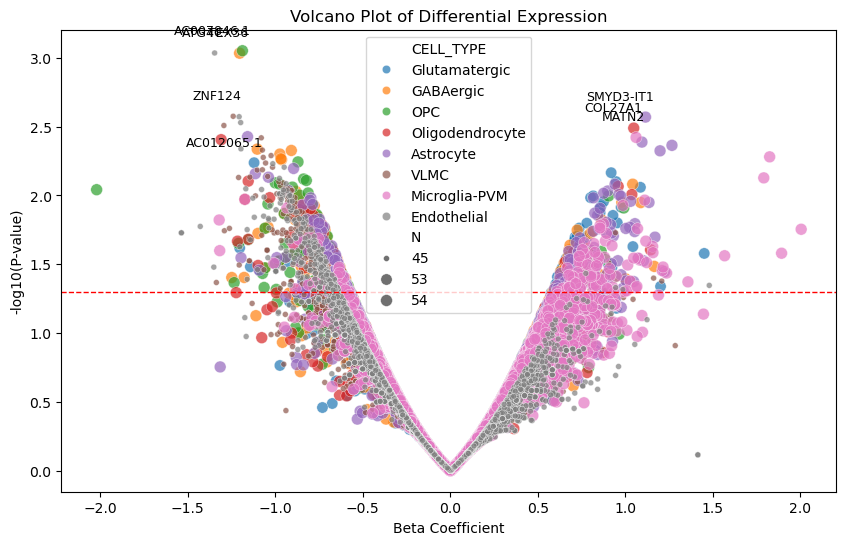

,CELL_TYPE,ENSG,BETA,SE,P,N,minus_log10_p,gene_name
135364,Astrocyte,ENSG00000230184,1.114820,0.371575,0.002698,54,2.569036,SMYD3-IT1
216927,Endothelial,ENSG00000125703,-1.346512,0.406441,0.000923,45,3.034687,ATG4C
52360,GABAergic,ENSG00000175018,-1.203926,0.363515,0.000927,54,3.033088,TEX36
3490,Glutamatergic,ENSG00000227047,-1.121059,0.406233,0.005786,53,2.237593,AC012065.1
199754,Microglia-PVM,ENSG00000132561,1.060962,0.366479,0.003791,54,2.421201,MATN2
92731,OPC,ENSG00000284837,-1.187698,0.357370,0.000889,54,3.051031,AC007846.1
115111,Oligodendrocyte,ENSG00000196739,1.047519,0.355853,0.003243,54,2.489009,COL27A1
166994,VLMC,ENSG00000196418,-1.240405,0.412879,0.002662,45,2.574778,ZNF124


In [16]:
top_hits_by_cell_type = simple_volcano(de_results, pb.var.copy())
top_hits_by_cell_type

## 4. Compositional Analysis of Prefrontal Cortex Cells

Understanding how different cell types are represented across conditions is a foundational step in interpreting single-cell datasets, especially in neurodegeneration. 

Here, we analyze composition across three levels.

### 4.1 Global Cell-Type Abundance by Primary Diagnosis

First, we compare **absolute cell counts** across cell types. This highlights dataset-level differences (e.g., fewer neurons overall in PD samples, higher glial representation).

> These counts are influenced by sampling depth and cell recovery, not just biology, so we complement them with proportional analysis.

In [17]:
# Use the obs table from your AnnData
obs = adata.obs.copy() 

# Make sure the columns exist – adjust names if needed
obs = obs.rename(columns={
    "cell_type": "Cell type",
    "primary_diagnosis": "Primary diagnosis",  
})
# Group and count cells per (Cell type, Disease status)
plot_data_global = (
    obs
    .groupby(["Cell type", "Primary diagnosis"], observed=True)
    .size()
    .reset_index(name="count")
)

plot_data_global.head()


,Cell type,Primary diagnosis,count
0,Astrocyte,Healthy Control,3830
1,Astrocyte,Idiopathic PD,13893
2,Astrocyte,No PD nor other neurological disorder,7511
3,Endothelial,Healthy Control,111
4,Endothelial,Idiopathic PD,196


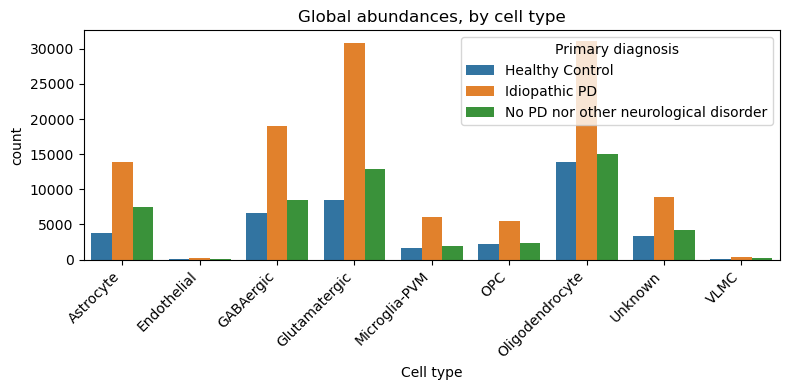

In [18]:
plt.figure(figsize=(8, 4))
sns.barplot(
    data=plot_data_global,
    x="Cell type",
    y="count",
    hue="Primary diagnosis"
)
plt.title("Global abundances, by cell type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 4.2 Proportional Cell-Type Abundance by Primary Diagnosis

Next, we normalize within each diagnostic group to calculate **relative cellular proportions**:

The proportion is calculated as:  
$\text{proportion} = \frac{\text{cells of type } i}{\text{total cells in diagnosis}}$

> Proportional analysis controls for uneven sample sizes and sequencing depth.


In [19]:
# Use reference, not copy (safe unless you're modifying columns)
obs = adata.obs

# Precompute total cells per diagnosis once
diag_totals = obs.groupby("primary_diagnosis", observed=True)["cell_type"].size()

# Compute counts per (diagnosis × cell_type)
comp_global = (
    obs.groupby(["primary_diagnosis", "cell_type"], observed=True)
       .size()
       .reset_index(name="n_cells")
)

# Merge totals instead of transform(lambda)
comp_global = comp_global.merge(
    diag_totals.rename("diag_total"),
    on="primary_diagnosis",
    how="left"
)

# Compute proportion
comp_global["prop_within_diag"] = comp_global["n_cells"] / comp_global["diag_total"]

comp_global.head()


,primary_diagnosis,cell_type,n_cells,diag_total,prop_within_diag
0,Healthy Control,Astrocyte,3830,40204,0.095264
1,Healthy Control,Endothelial,111,40204,0.002761
2,Healthy Control,GABAergic,6579,40204,0.163640
3,Healthy Control,Glutamatergic,8478,40204,0.210875
4,Healthy Control,Microglia-PVM,1594,40204,0.039648


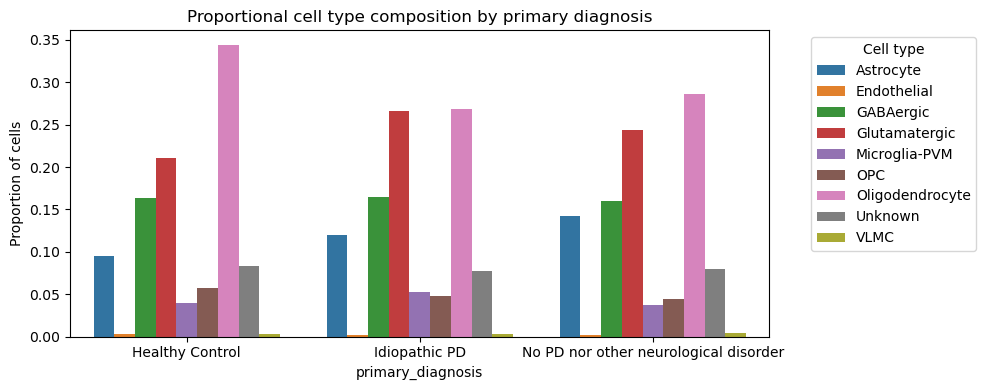

In [20]:
plt.figure(figsize=(10, 4))
sns.barplot(
    data=comp_global,
    x="primary_diagnosis",
    y="prop_within_diag",
    hue="cell_type"
)
plt.ylabel("Proportion of cells")
plt.title("Proportional cell type composition by primary diagnosis")
plt.legend(title="Cell type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### 4.3 Subtype Composition by Diagnosis

We refine composition using subclass annotations. This identifies which neuronal populations exhibit selective depletion, providing biological insight into PD pathology.


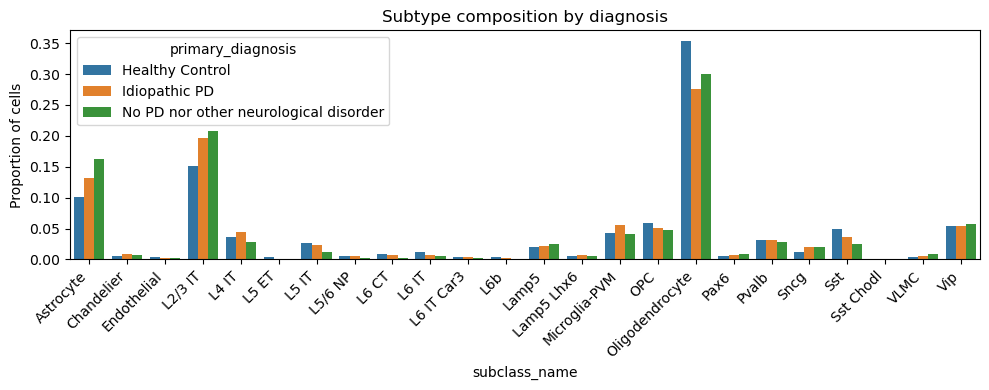

In [21]:
# Aggregate by Diagnosis and Cell subclass 
comp = (
    adata.obs.groupby(["primary_diagnosis", "subclass_name"], observed=True)
      .size()
      .reset_index(name="n_cells")
)

# Proportions within diagnosis
comp["prop"] = comp.groupby("primary_diagnosis", observed=True)["n_cells"].transform(lambda x: x / x.sum())

plt.figure(figsize=(10,4))
sns.barplot(data=comp, x="subclass_name", y="prop", hue="primary_diagnosis")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Proportion of cells")
plt.title("Subtype composition by diagnosis")
plt.tight_layout()
plt.show()



#### **Summary**

Together, these three perspectives provide a multi-resolution view of composition:

| Level | Biological Question | Example Interpretation |
|-------|--------------------|------------------------|
| **Global counts** | How many cells were recovered? | PD samples yield fewer neurons overall |
| **Proportional composition** | What fraction of each sample is each cell type? | Glial proportion increases in PD |
| **Subtype-resolved** | Which neuronal groups are most affected? | L5 IT neurons depleted; microglia expanded |

These insights guide downstream hypotheses, differential expression tests, and pathway analysis.


## 5. Provenance

This notebook was generated as part of the **ASAP-CRN Verily Workbench Learning Lab** to demonstrate a downstream analysis workflow using harmonized single-nucleus RNA-seq data from the ASAP Collaborative Research Network.

### **Software & Environment**
- Platform: **Verily Workbench**
- Runtime: Cloud app environment - Jupyter Lab (Python)
- Key libraries: `scanpy`, `anndata`, `pandas`, `numpy`, `matplotlib`, `seaborn`
- Data format: `AnnData` (`.h5ad`)

### **Notebook-Generated Outputs**
This notebook produces intermediate artifacts stored locally under: `ws_files/pilot_workshop_files/`

In [22]:
!date

Thu Nov 20 11:09:11 PM UTC 2025


In [23]:
!jupyter labextension list

[W 2025-11-20 23:09:15.074 LabApp] 'kernel_spec_manager_class' has moved from NotebookApp to ServerApp. This config will be passed to ServerApp. Be sure to update your config before our next release.
JupyterLab v4.3.4
/opt/conda/envs/jupyter/share/jupyter/labextensions
        nbdime-jupyterlab v3.0.2 enabled OK
        jupyterlab-jupytext v1.4.3 enabled OK (python, jupytext)
        jupyterlab_pygments v0.3.0 enabled OK (python, jupyterlab_pygments)
        jupyterlab-plotly v5.24.1 enabled  X
        @jupyterlab/git v0.51.2 enabled OK (python, jupyterlab-git)
        @jupyter-widgets/jupyterlab-manager v5.0.13 enabled OK (python, jupyterlab_widgets)


   The following extensions may be outdated or specify dependencies that are incompatible with the current version of jupyterlab:
        jupyterlab-plotly
        
   If you are a user, check if an update is available for these packages.
   If you are a developer, re-run with `--verbose` flag for more details.



In [24]:
print("Number of cores:")
!grep ^processor /proc/cpuinfo | wc -l

Number of cores:
16


In [25]:
print("Memory") 
!grep "^MemTotal:" /proc/meminfo

Memory
MemTotal:       65839120 kB


## 6. Next Steps

You’ve now completed the **ASAP-CRN Learning Lab Pilot Workshop Series**—great work!

At this point, you have learned how to:

- navigate Verily Workbench and duplicate workspaces  
- explore curated ASAP-CRN datasets and metadata  
- subset data for analysis (prefrontal cortex case/control workflow)  
- perform initial exploratory and compositional analyses  
- construct simple pseudobulk profiles for downstream modeling  
- run a basic differential expression screening workflow

This foundation prepares you to transition from guided examples to **your own research questions.**

---

### **Where to go from here**

**Continue analysis in any of the workshop notebooks**  
- Try swapping `cell_type` for `subclass_name`  
- Explore alternative filtering criteria  
- Expand to other brain regions or conditions

**Start a new notebook for your study**  
- Copy sections from this template as needed  
- Load different datasets from the ASAP-CRN collections  
- Apply your own QC and cell annotation pipeline

**Move toward production workflows**  
- Use robust DE pipelines (edgeR, DESeq2, limma-voom, mixed models)
- Apply trajectory, network, or pathway analyses

**Share improvements**  
Contribute updated notebooks, visualizations, or workflows to the Learning Lab repo to help the community.

---

### Final Note

These notebooks are starting points—> your scientific insight drives the next phase.  
Use what you’ve learned here to design analyses that answer meaningful biological questions, deepen understanding of Parkinson’s disease, and contribute back to the CRN research ecosystem.

**Onward to discovery. 🚀**


---

<p align="center">
  <a href="https://asap-crn.github.io/asap-crn-learning-lab/" target="_blank">
    <img src="https://img.shields.io/badge/Back_to_ASAP_CRN_Learning_Lab-5038A1?style=for-the-badge&logo=github&logoColor=white" alt="Return to Learning Lab">
  </a>
</p>

---
